# Live cu-inj-live-impact 

In [1]:
# Setup directories, and convert dashboard notebook to a script for importing
#!./setup.bash

In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
from impact import evaluate_impact_with_distgen, run_impact_with_distgen
from impact.tools import isotime
from impact.evaluate import  default_impact_merit
from impact import Impact

from make_dashboard import make_dashboard
from get_vcc_image import get_live_distgen_xy_dist, VCC_DEVICE_PV

import matplotlib as mpl

from pmd_beamphysics.units import e_charge

In [4]:
import pandas as pd
import numpy as np

import h5py
import json
import epics

import sys
import os
from time import sleep, time


import matplotlib.pyplot as plt

#import matplotlib as mpl
#mpl.use('Agg')

# Nicer plotting
%config InlineBackend.figure_format = 'retina'

# Logging

In [5]:
MODEL = 'f2e_inj'
#MODEl = 'cu_inj'

In [6]:
PREFIX = f'lume-impact-live-demo-{MODEL}'

In [7]:
import logging

# Gets or creates a logger
logger = logging.getLogger(PREFIX)  

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler(f'{PREFIX}.log')
#formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
formatter    = logging.Formatter(fmt="%(asctime)s :  %(name)s : %(message)s ", datefmt="%Y-%m-%dT%H:%M:%S%z")

# Add print to stdout
logger.addHandler(logging.StreamHandler(sys.stdout))

file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

# Configuration

Set up basic input sources and output path.

Depends on the `$LCLS_LATTICE` environmental variable pointing to a checked out copy of https://github.com/slaclab/lcls-lattice (protected)

In [8]:
DEBUG = False

ROOT = os.getcwd()

WORKDIR=os.path.expandvars('$SCRATCH')

In [9]:
# Directory for summary output
OUTPUTDIR = os.path.join(ROOT, 'output')

# Directory to output plots
PLOTDIR = os.path.join(ROOT, 'plot')

# Directory for archive files
APATH = os.path.join(ROOT, 'archive')

# Directory for EPICS snapshot files
SNAPSHOT_PATH = os.path.join(ROOT, 'snapshot')


# Dummy file for distgen
DISTGEN_LASER_FILE = os.path.join(ROOT, 'distgen_laser.txt')

# Base settings
SETTINGS0 = {
 
 'distgen:n_particle': 100_000,   
 #'stop': 16.5, 
 'timeout': 10000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 #'total_charge': 0, # Set to 0 to turn off Space Charge for faster execution 
# 'change_timestep_1:dt':4e-12, 
 
 # Parallel control
 'numprocs': 64,
    
 # SDF setup    
 'command': '/sdf/home/c/cmayes/impact/bin/ImpactTexe',    
 'command_mpi': '/sdf/home/c/cmayes/impact/bin/ImpactTexe-mpi',
 'mpi_run': 'salloc --partition ard -N 1 -n {n} /sdf/sw/gcc-4.8.5/openmpi-4.0.4/bin/mpirun -n {n} {command_mpi}'
   }

if DEBUG:
    logger.info('DEBUG MODE: Running without space charge for speed. ')
    SETTINGS0['distgen:n_particle'] =1000
    SETTINGS0['total_charge'] = 0
    SETTINGS0['numprocs'] = 32

# Select: LCLS or FACET

In [10]:
# PV -> Sim conversion table
CSV =  f'pv_mapping/{MODEL}_impact.csv'  


if MODEL == 'cu_inj':
    CONFIG0 = {'impact_config': os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/v0/ImpactT.yaml'),
          'distgen_input_file': os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/vcc_image/distgen.yaml')
              }
    
    VCC_DEVICE = 'CAMR:IN20:186' # LCLS   
    
    DASHBOARD_KWARGS = {'outpath':PLOTDIR,
                    'screen1': 'YAG02',
                    'screen2': 'YAG03',
                    'screen3': 'OTR2'
                   }    
    
    SETTINGS0['stop'] = 16.5
    SETTINGS0['distgen:t_dist:length:value'] =  4 * 1.65 ,     #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
    
elif MODEL == 'f2e_inj':
    CONFIG0 = {'impact_config': os.path.expandvars('$FACET2_LATTICE/impact/models/f2e_inj/v0/ImpactT.yaml'),
          'distgen_input_file': os.path.expandvars('$FACET2_LATTICE/distgen/models/f2e_inj/vcc_image/distgen.yaml')
              }
    
    VCC_DEVICE = 'CAMR:LT10:900' # FACET-II
    
    DASHBOARD_KWARGS = {'outpath':PLOTDIR,
                    'screen1': 'PR10241',
                    'screen2': 'PR10465',
                    'screen3': 'PR10571',
                    'ylim' : (0, 20e-6), # Emittance scale
                    'name' : PREFIX
                   }        
    
    SETTINGS0['distgen:t_dist:length:value'] =  3.65 * 1.65   #  Measured FWHM: 3.65 ps, converted to tukey length
     
else:
    raise

# Set up monitors

In [11]:
DF = pd.read_csv(CSV)#.dropna()

PVLIST = list(DF['device_pv_name'].dropna()) + list(VCC_DEVICE_PV[VCC_DEVICE].values())

#DF.set_index('device_pv_name', inplace=True)
DF

,Variable,bmad_name,device_pv_name,pv_unit,impact_name,impact_factor,impact_description,impact_unit
0,Solenoid,SOL10111,SOLN:IN10:121:BACT,kG*m,SOL10111:solenoid_field_scale,5.142724e-01,peak field,T
1,Bucking Coil,NaN,SOLN:IN10:111:BACT,kG*m,NaN,NaN,NaN,NaN
2,Corrector quad,CQ10121,QUAD:IN10:121:BACT,kG,CQ10121:b1_gradient,-4.761905e-01,Corrector quad gradient,T/m
3,Skew quad,SQ10122,QUAD:IN10:122:BACT,kG,SQ10122:b1_gradient,-4.761905e-01,Skew quad gradient,T/m
4,L0AF phase,L0AF,NaN,deg,L0AF_phase:dtheta0_deg,1.000000e+00,Phase relative to on-crest,deg
5,L0BF phase,L0BF,NaN,deg,L0BF_phase:dtheta0_deg,1.000000e+00,Phase relative to on-crest,deg
6,L0BF voltage,L0AF,NaN,MV,L0AF_scale:voltage,1.000000e+06,Voltage,V
7,L0BF voltage,L0BF,NaN,MV,L0BF_scale:voltage,1.000000e+06,Voltage,V
8,QA10361,QA10361,QUAD:IN10:361:BACT,kG,QA10361:b1_gradient,-9.259259e-01,10.8 cm quad,T/m
9,QA10371,QA10371,QUAD:IN10:371:BACT,kG,QA10371:b1_gradient,-9.259259e-01,10.8 cm quad,T/m


In [12]:
MONITOR = {pvname:epics.PV(pvname) for pvname in PVLIST}
sleep(5)

In [13]:
def get_pvdata():
        
    itime = isotime()
    pvdata =  {k:MONITOR[k].get() for k in MONITOR}
    
    logger.info(f'Acquired settings from EPICS at: {itime}')
    
    for k, v in pvdata.items():
        
        if v is None:
            raise ValueError(f'EPICS get for {k} returned None')
        
        if ':IMAGE' in k.upper():
            pvdata[k] = v.astype(np.int8) # Downcast preeptively 
            if v.ptp() == 0:
                raise ValueError(f'EPICS get for {k} has zero extent')

    return pvdata, itime
PVDATA, ITIME = get_pvdata()
PVDATA, ITIME

Acquired settings from EPICS at: 2021-12-05T16:49:26-08:00


({'SOLN:IN10:121:BACT': 0.42024973448290603,
  'SOLN:IN10:111:BACT': 8.86709389154139e-06,
  'QUAD:IN10:121:BACT': 3.437843805266109e-06,
  'QUAD:IN10:122:BACT': 0.005621006545909657,
  'QUAD:IN10:361:BACT': -3.7837677181250626,
  'QUAD:IN10:371:BACT': 3.2800752329261904,
  'QUAD:IN10:425:BACT': -6.312498316201904,
  'QUAD:IN10:441:BACT': 5.3567148524401365,
  'QUAD:IN10:511:BACT': 5.413577882570432,
  'QUAD:IN10:525:BACT': -8.17228758770488,
  'BPMS:IN10:371:TMIT': 30868562.0,
  'CAMR:LT10:900:Image:ArrayData': array([9, 1, 4, ..., 1, 0, 2], dtype=int8),
  'CAMR:LT10:900:ArraySizeX_RBV': 1388,
  'CAMR:LT10:900:ArraySizeY_RBV': 1038,
  'CAMR:LT10:900:RESOLUTION': 6.85,
  'CAMR:LT10:900:RESOLUTION.EGU': 'um/px'},
 '2021-12-05T16:49:26-08:00')

In [14]:
# Saving and loading
def save_pvdata(filename, pvdata, isotime):
    with h5py.File(filename, 'w') as h5:
        h5.attrs['isotime'] = np.string_(isotime)
        for k, v in pvdata.items():
            if isinstance(v, str):
                v =  np.string_(v)
            h5[k] = v 
def load_pvdata(filename):
    pvdata = {}
    with h5py.File(filename, 'r') as h5:
        isotime = h5.attrs['isotime']
        for k in h5:
            v = np.array(h5[k])        
            if v.dtype.char == 'S':
                v = str(v.astype(str))
            pvdata[k] = v
            
    return pvdata, isotime
save_pvdata('test.h5', PVDATA, isotime()) 
load_pvdata('test.h5')

({'BPMS:IN10:371:TMIT': array(30868562.),
  'CAMR:LT10:900:ArraySizeX_RBV': array(1388),
  'CAMR:LT10:900:ArraySizeY_RBV': array(1038),
  'CAMR:LT10:900:Image:ArrayData': array([9, 1, 4, ..., 1, 0, 2], dtype=int8),
  'CAMR:LT10:900:RESOLUTION': array(6.85),
  'CAMR:LT10:900:RESOLUTION.EGU': 'um/px',
  'QUAD:IN10:121:BACT': array(3.43784381e-06),
  'QUAD:IN10:122:BACT': array(0.00562101),
  'QUAD:IN10:361:BACT': array(-3.78376772),
  'QUAD:IN10:371:BACT': array(3.28007523),
  'QUAD:IN10:425:BACT': array(-6.31249832),
  'QUAD:IN10:441:BACT': array(5.35671485),
  'QUAD:IN10:511:BACT': array(5.41357788),
  'QUAD:IN10:525:BACT': array(-8.17228759),
  'SOLN:IN10:111:BACT': array(8.86709389e-06),
  'SOLN:IN10:121:BACT': array(0.42024973)},
 b'2021-12-05T16:49:26-08:00')

In [15]:
#while True:
#    get_pvdata()

# EPICS -> Simulation settings

In [16]:
def get_live_settings(csv, base_settings={}, snapshot_dir=None):
    """
    Fetches live settings for all devices in the CSV table, and translates them to simulation inputs
     
    """
    df = DF.copy().dropna()

    pv_names = list(df['device_pv_name'])

    pvdata, itime = get_pvdata()
    
    if snapshot_dir:
        filename = os.path.abspath(os.path.join(snapshot_dir, f'{MODEL}-snapshot-{itime}.h5'))
        logger.info(f'EPICS shapshot written: {filename}')
        save_pvdata(filename, pvdata, itime)
        # DEBUG: check readback
        #pvdata, itime = load_pvdata(filename)
        
    #df['pv_value'] = epics.caget_many(pv_names)
    df['pv_value'] = [pvdata[k] for k in pv_names]
    
    # Assign impact
    df['impact_value'] = df['impact_factor']*df['pv_value'] 

    # Collect settings
    settings = base_settings.copy()
    settings.update(dict(zip(df['impact_name'], df['impact_value'])))

    # VCC image
    dfile, img, cutimg = get_live_distgen_xy_dist(filename=DISTGEN_LASER_FILE, vcc_device=VCC_DEVICE, pvdata=pvdata)
    settings['distgen:xy_dist:file'] = dfile
    
    return settings, df, img, cutimg, itime

res = get_live_settings(CSV, SETTINGS0, snapshot_dir='.')
#DF[['Variable', 'bmad_name', 'pv_value','pv_unit',  'device_min', 'device_max',  'impact_name', 'impact_factor', 'impact_unit',
#        'impact_description',  'impact_value']]
res[-1]

Acquired settings from EPICS at: 2021-12-05T16:49:26-08:00
EPICS shapshot written: /sdf/home/c/cmayes/GitHub/lume-impact-live-demo/f2e_inj-snapshot-2021-12-05T16:49:26-08:00.h5


'2021-12-05T16:49:26-08:00'

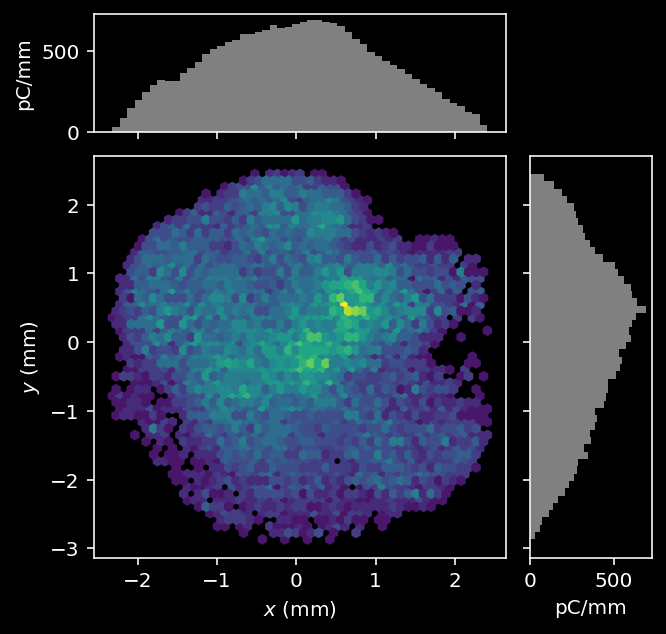

In [17]:
gfile = CONFIG0['distgen_input_file']
from distgen import Generator
#fout = res[0]
G = Generator(gfile)
G['xy_dist:file'] =  'distgen_laser.txt'
G['n_particle'] = 10000
G.run()
G.particles.plot('x', 'y', figsize=(5,5))

In [18]:
#CONFIG0

In [19]:
#%%time
#I0 = run_impact_with_distgen(LIVE_SETTINGS,  workdir=WORKDIR, **CONFIG0, verbose=True )

In [20]:
DO_TIMING = False

if DO_TIMING:
    import numpy as np
    import time
    results = []
    tlist = []
    nlist = 2**np.arange(1,8, 1)[::-1]
    for n in nlist:
        t1 = time.time()
        LIVE_SETTINGS['numprocs'] = n
        print(f'running wit {n}')
        result = run_impact_with_distgen(LIVE_SETTINGS,  workdir=WORKDIR, **CONFIG0, verbose=False )
        results.append(result)
        dt = time.time() - t1
        tlist.append(dt)
        print(n, dt)     
        
    tlist, nlist        

In [21]:
# %matplotlib inline
# I0.plot(['norm_emit_x'], y2=['sigma_x'], ylim=(0, 10e-6), ylim2=(0,2e-3), figsize=(16,9))

In [22]:
#I0.initial_particles.plot('x', 'y')

# Get live values, run Impact-T, make dashboard

In [23]:
# Patch this into the function below for the dashboard creation
def my_merit(impact_object, itime):
    # Collect standard output statistics
    merit0 = default_impact_merit(impact_object)
    # Make the dashboard from the evaluated object
    plot_file = make_dashboard(impact_object, itime=itime, **DASHBOARD_KWARGS)
    #print('Dashboard written:', plot_file)
    logger.info(f'Dashboard written: {plot_file}')
    
    # Assign extra info
    merit0['plot_file'] = plot_file    
    merit0['isotime'] = itime
    
    # Clear any buffers
    plt.close('all')

    return merit0

In [24]:
#my_merit(I0, '123')

In [25]:
def run1():
    dat = {}
    
    # Acquire settings
    mysettings, df, img, cutimg, itime = get_live_settings(CSV, SETTINGS0, snapshot_dir=SNAPSHOT_PATH)
    
    
    dat['isotime'] = itime
    
    # Record inputs
    dat['inputs'] = mysettings
    dat['config'] = CONFIG0
    dat['pv_mapping_dataframe'] = df.to_dict()
    
    

    logger.info(f'Running evaluate_impact_with_distgen...')
    
    t0 = time()
    dat['outputs'] = evaluate_impact_with_distgen(mysettings,
                                       merit_f=lambda x: my_merit(x, itime),
                                       archive_path=APATH,
                                       workdir=WORKDIR,
                                       **CONFIG0 )
    logger.info(f'...finished in {(time()-t0)/60:.1f} min')
    fname = fname=f'{OUTPUTDIR}/{PREFIX}-{itime}.json'
    json.dump(dat, open(fname, 'w'))
    #print('Written:', fname)
    logger.info(f'Output written: {fname}')
    return dat
    

In [26]:
%%time
# Here are the results
result = run1()
result.keys()

Acquired settings from EPICS at: 2021-12-05T16:49:30-08:00
EPICS shapshot written: /sdf/home/c/cmayes/GitHub/lume-impact-live-demo/snapshot/f2e_inj-snapshot-2021-12-05T16:49:30-08:00.h5
Running evaluate_impact_with_distgen...


/sdf/home/c/cmayes/miniconda3/envs/lume-live/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Dashboard written: /sdf/home/c/cmayes/GitHub/lume-impact-live-demo/plot/lume-impact-live-demo-2021-12-05T16:49:30-08:00-dashboard.png
...finished in 2.8 min
Output written: /sdf/home/c/cmayes/GitHub/lume-impact-live-demo/output/lume-impact-live-demo-f2e_inj-2021-12-05T16:49:30-08:00.json
CPU times: user 15.9 s, sys: 8.06 s, total: 23.9 s
Wall time: 2min 48s


dict_keys(['isotime', 'inputs', 'config', 'pv_mapping_dataframe', 'outputs'])

In [27]:
# Basic config
#result['config']

In [28]:
# Simulation inputs
#result['inputs']

In [29]:
# Simulation outputs
#result['outputs']

# Show the plot 

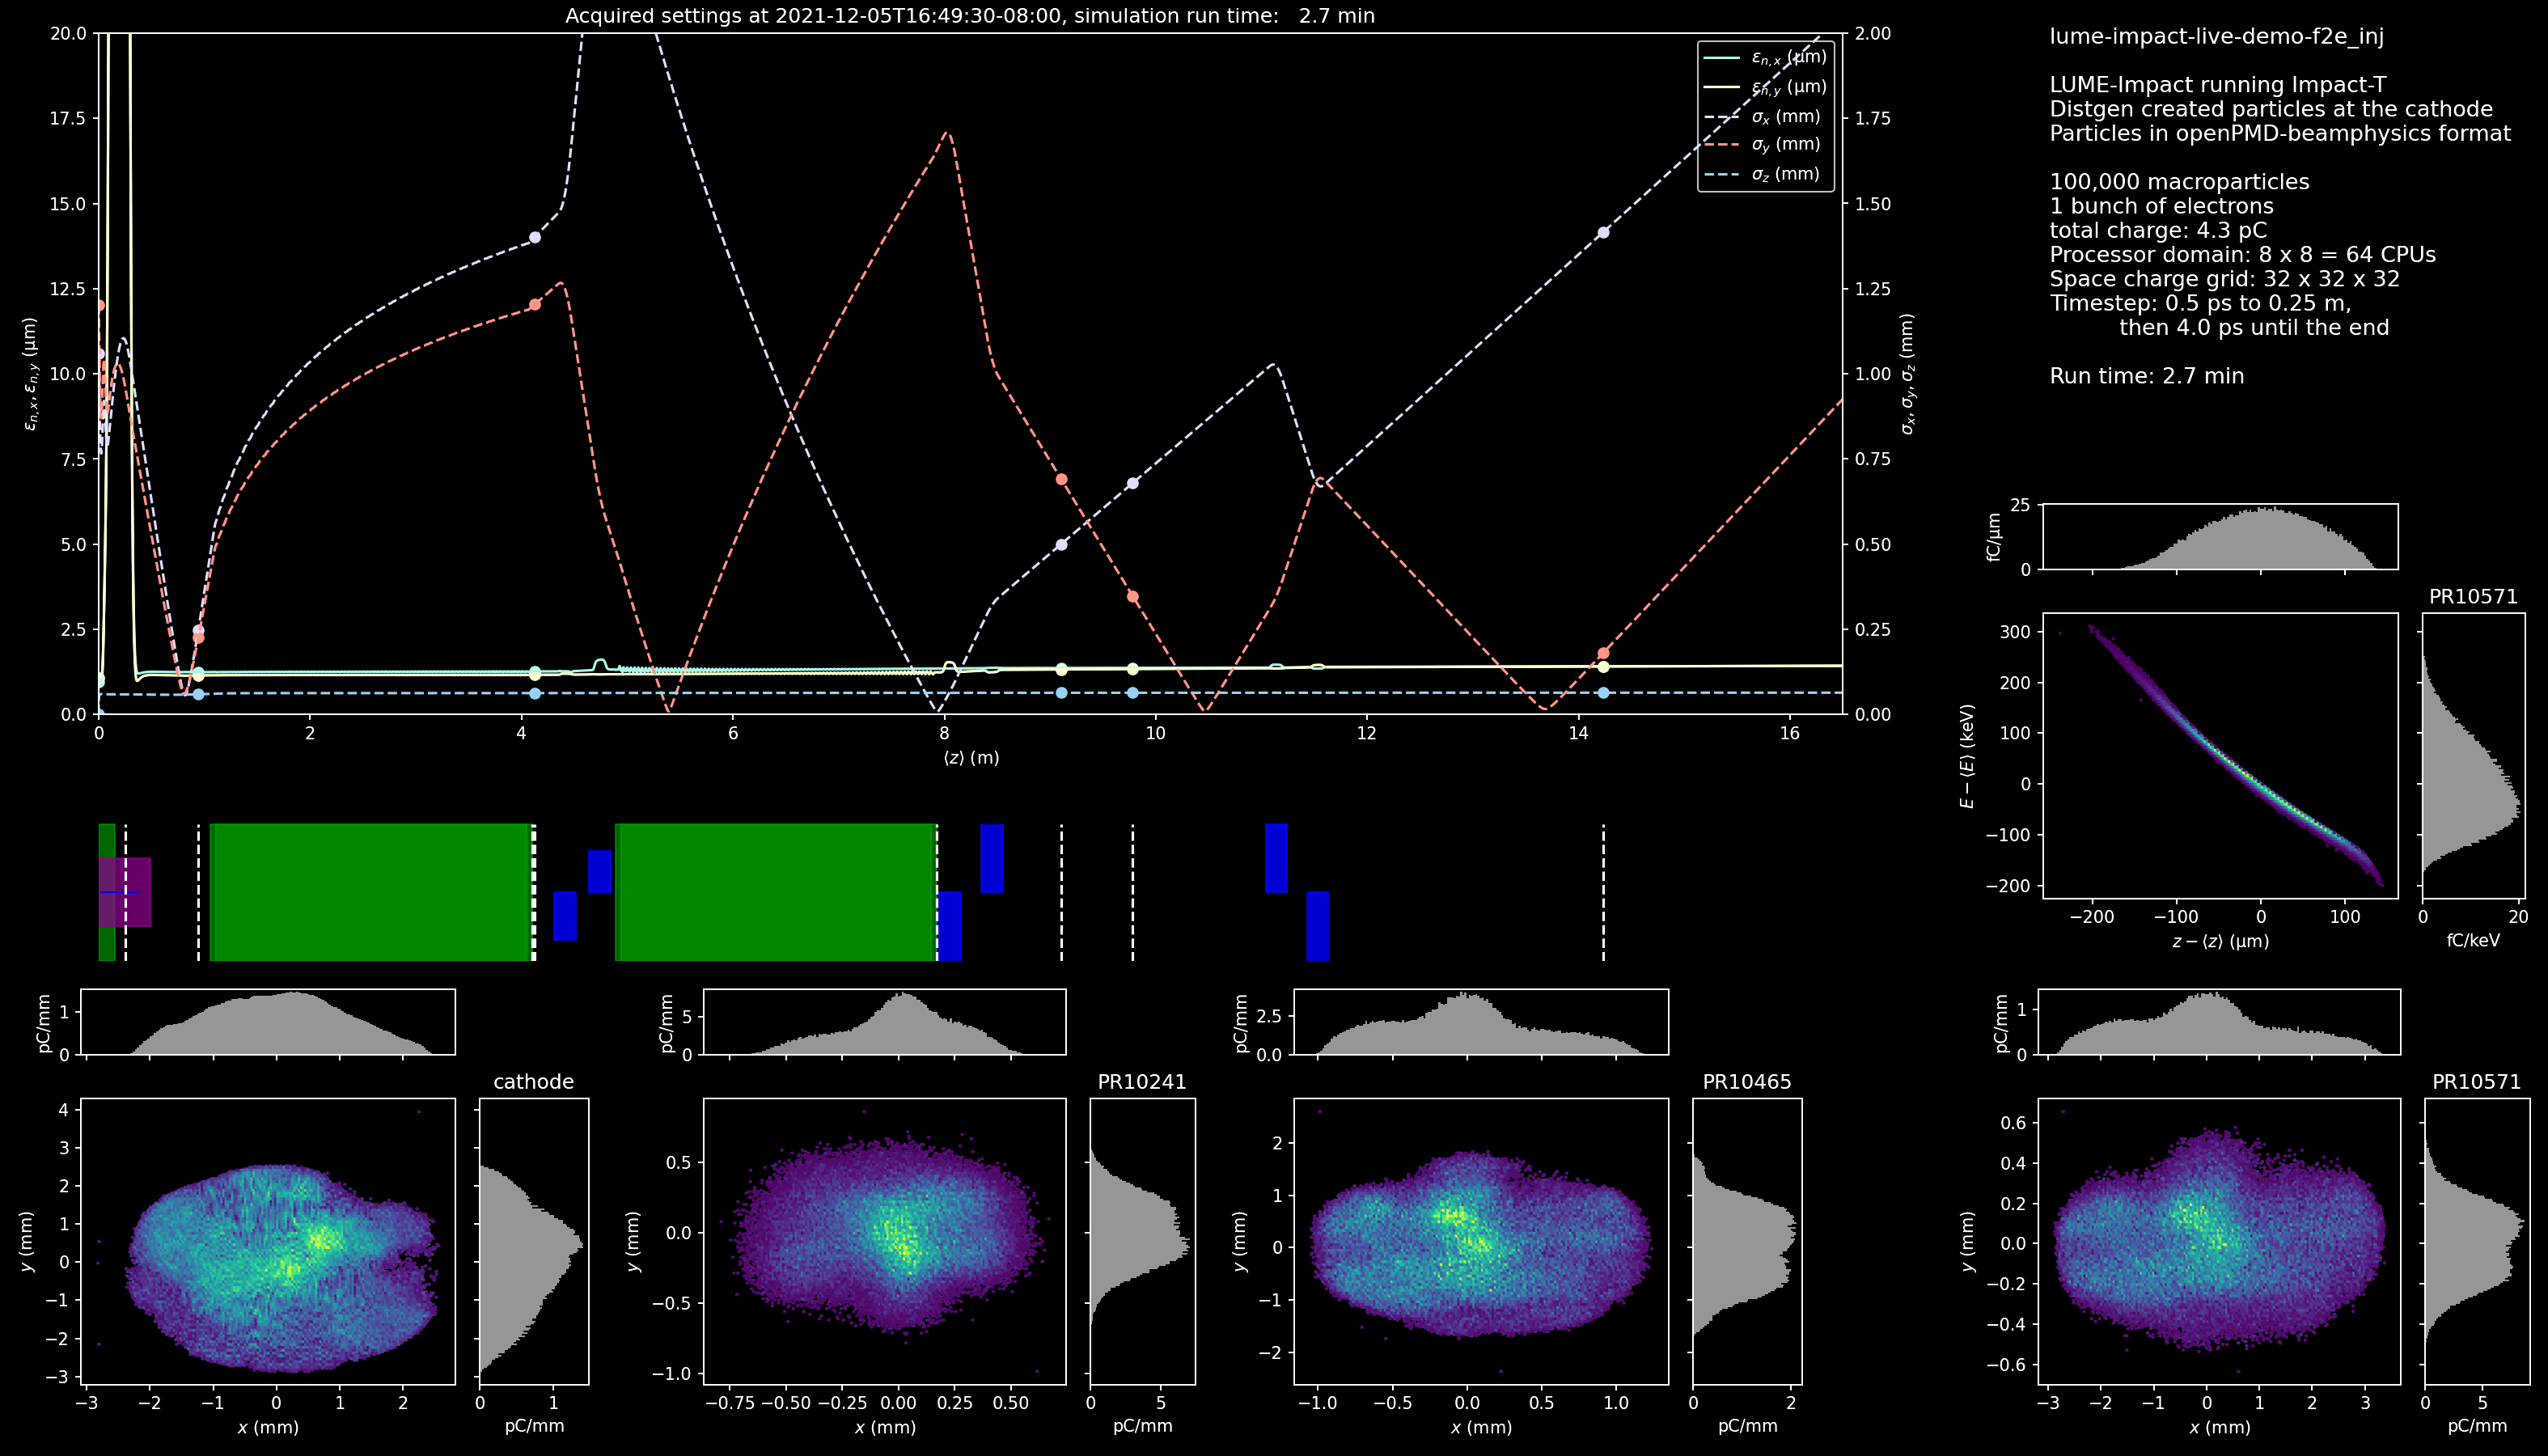

In [30]:
from IPython.display import Image
Image(filename=result['outputs']['plot_file']) 

# loop it


In [ ]:
if __name__ == '__main__':
    while True:
        try:
            run1()
        except:
            sleep(10)
            logger.info('Something BAD happened. Sleeping for 10 s ...')